In [1]:
import pandas as pd
import networkx as nx
import numpy as np
from scipy.special import loggamma

In [2]:
df = pd.read_csv("./example/example.csv")
node_names = {}
for i, name in enumerate(df.columns):
    node_names[i] = name
G = nx.DiGraph()
G.add_nodes_from(range(len(df.columns)))
G.add_edge(0, 1)
G.add_edge(2, 3)
G.add_edge(4, 5)

In [101]:
def statistics(G, df):
    r = df.max().to_numpy()
    q = [np.prod([r[j] for j in preds[1]], dtype=int) for preds in G.pred.items()]
    M = [np.zeros((q[node], r[node])) for node in G]
    
    prior = [np.ones((q[node], r[node])) for node in G]
    
    df2 = df.copy()
    df2.columns = list(range(len(df.columns)))

    for i in G:
        parents = list(G.predecessors(i))
        parents.append(i)
        group = df2.groupby(parents)

        series = group[i].count()

        if isinstance(series.index, pd.MultiIndex):
            multi_index = []
            for node in reversed(parents):
                multi_index.append([value for value in range(1, r[node]+1)])

            new_index = pd.MultiIndex.from_product(multi_index)

            series = series.reindex(new_index, fill_value=0)

            M[i] += series.array.reshape((M[i].shape))
        else:
            M[i][0, :] += series.array
            
    return M, prior

In [102]:
def bayesian_score_component(M, alpha):
    p = np.sum(loggamma(alpha + M))
    p -= np.sum(loggamma(alpha))
    p += np.sum(loggamma(np.sum(alpha, axis=1)))
    p -= np.sum(loggamma(np.sum(alpha, axis=1) + np.sum(M, axis=1)))
    return p

def bayesian_score(G, df):
    M, alpha = statistics(G, df)
    return np.sum(bayesian_score_component(M[node], alpha[node]) for node in G)


In [103]:
score = bayesian_score(G, df)
print(score)

-132.02362143513778


/var/folders/bh/99gmfn390k967_3pnjc4y4c80000gn/T/ipykernel_17135/3287513580.py:10: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(bayesian_score_component(M[node], alpha[node]) for node in G)


In [29]:
M, alpha = statistics(G, df)

In [30]:
r = df.max().to_numpy()
r

array([3, 3, 3, 3, 3, 3])

In [31]:
q = [np.prod([r[j] for j in preds[1]], dtype=int) for preds in G.pred.items()]
q

[1, 3, 1, 3, 1, 3]

In [19]:
for index, row in df.iterrows():
    for i in G:
        k = row[i] - 1
        parents = list(G.predecessors(i))
        j = 0
        if len(parents):
            parents_size = np.array(r)[parents]
            coordinate = row[parents] - 1
            j = np.ravel_multi_index(tuple(coordinate), tuple(parents_size))
        M[i][j, k] += 1

In [99]:
M = [np.zeros((q[node], r[node])) for node in G]

df2 = df.copy()
df2.columns = list(range(len(df.columns)))

for i in G:
    parents = list(G.predecessors(i))
    parents.append(i)
    group = df2.groupby(parents)
    
    series = group[i].count()
    
    if isinstance(series.index, pd.MultiIndex):
        multi_index = []
        for node in reversed(parents):
            multi_index.append([value for value in range(1, r[node]+1)])
            
        new_index = pd.MultiIndex.from_product(multi_index)

        series = series.reindex(new_index, fill_value=0)

        M[i] += series.array.reshape((M[i].shape))
    else:
        M[i][0, :] += series.array

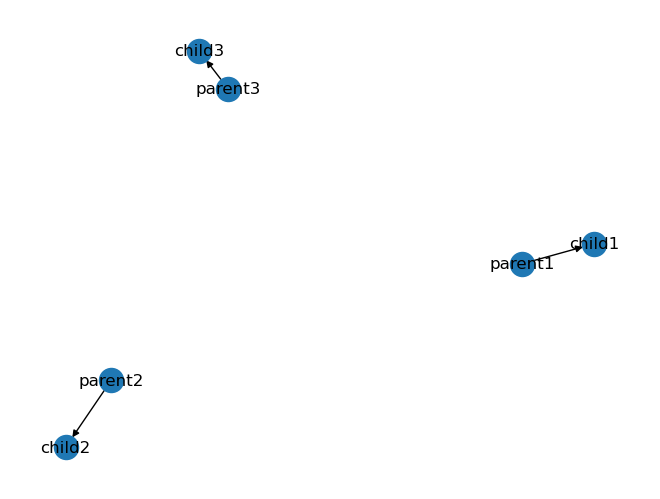

In [77]:
nx.draw(G, labels=node_names, with_labels=True)